In [34]:
# import standard libraries
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import autograd.numpy.random as npr
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys
import time

# import our libraries
import bayes_helpers as bh
from utils import generate_data, run_toy_nn
from feed_forward import Feedforward
from nlm import NLM
from luna import LUNA

### Generate Cubic Dataset

Generates 100 datapoints for train and 100 points for test according to the function

$$y = \frac{1}{2}x^3 + \epsilon$$

$$\epsilon \sim N(0, 3^2)$$

In [35]:
x_train, y_train, x_test = generate_data()

### Define LUNA AND NLM Hyperameters

In [44]:
######################
### COMMMON PARAMS####
######################


####  activation function ####
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

#### optimization parameters ####
optimization_params = {'step_size':1e-3, 
          'max_iteration':1000, 
          'random_restarts':1,
          'optimizer':'adam'}

#### model parameters #####
prior_variance = .1 #1 # chosen in the paper. declared "reasonable". who decided this
y_noise_variance = 9 # needs to match what the dataset itself is

#### other ####
random = np.random.RandomState(0)

########################
#### LUNA SPECIFIC  ####
########################

luna_architecture = {'width': 50,
            'hidden_layers': 2,
            'input_dim': 1,
            'output_dim': 5, #number of auxiliary functions, # note, in NLM, below, we change to 1
            'activation_fn_type': activation_fn_type,
            'activation_fn_params': 'rate=1',
            'activation_fn': activation_fn}

regularization_param_luna = 1e-1 # in the paper they searched over 1e-3,...,1e3 and chose 1e-1 for regularization

similarity_param = 1e0 # in the paper they searched over 1e-3,...,1e3 and chose 1e0 for similarity

########################
#### NLM SPECIFIC  ####
########################

nlm_architecture = luna_architecture
nlm_architecture[output_dim] = 1
regularization_param_nlm = 8.37 #they chose this in the paper, what a beautifully specific number



### Train NLM

In [45]:
t0 = time.time()
nlm = NLM(prior_variance,y_noise_variance, regularization_param_nlm, architecture, random)
nlm.train(x_train,y_train, optimization_params)
print(f"time: {np.round(time.time() - t0, 3)} seconds")

 Iteration 900 lower bound 100137.44823816368; gradient mag: 16141.457530894213
Done Training
time: 1.493 seconds


### Train LUNA

In [46]:
t0 = time.time()
luna = LUNA(prior_variance, y_noise_variance, regularization_param_luna, similarity_param, architecture, random)
luna.train(x_train, y_train, optimization_params)
print(f"time: {np.round(time.time() - t0, 3)} seconds")

 Iteration 900 lower bound 1379.3900004549776; gradient mag: 184.20374013520745
Done Training
time: 10.721 seconds


### Compare Results
- notice they have identical post processing function calls

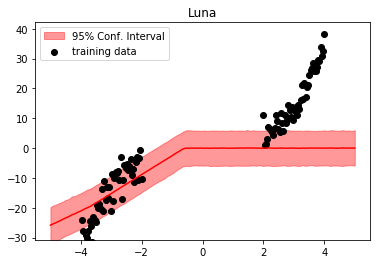

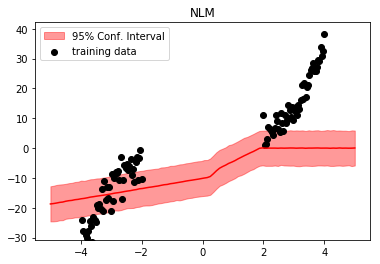

In [48]:
# fig, ax = plt.subplots(1,2, figsize = (12, 6))
i = 0
for name, model in {"Luna":luna,"NLM":nlm}.items():
    posterior_predictions, posterior_predictive_samples = model.predict(x_test)
    bh.viz_pp_samples(x_train, y_train,x_test.flatten(),posterior_predictive_samples,name)
#     lower, mean, upper = bh.get_percentile_interval(posterior_predictive_samples)
    
#     ax[i].plot(x_test, mean, color='red') # visualize the mean of the posterior predictive
#     ax[i].fill_between(x_test.reshape(-1), upper, lower, color='red', alpha=0.4, label='95% Pred. Interval') # visualize the 95% posterior predictive interval
#     ax[i].scatter(x_train, y_train, color='black', label='training data') # visualize the training data
#     ax[i].legend()
    
#     ax[i].set_title(name)
#     ax[i].set_xlim([-6, 6])
#     ax[i].set_ylim([-120, 120])
#     i+=1

other notes: 
 - trained on 100 points
 